# Clustering for Transaction Classification

This notebook covers use cases where your data is unlabelled but has features that can be used to cluster them into meaningful categories. The challenge with clustering is making the features that make those clusters stand out human-readable, and that is where we'll look to use GPT-3 to generate meaningful cluster descriptions for us. We can then use these to apply labels to a previously unlabelled dataset.

To feed the model we use embeddings created using the approach displayed in the notebook [Multiclass classification for transactions Notebook](Multiclass_classification_for_transactions.ipynb), applied to the full 359 transactions in the dataset to give us a bigger pool for learning

## Setup

In [1]:
# imports
import openai
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import os

openai.api_key = os.getenv("OPENAI_API_KEY")
COMPLETIONS_MODEL = "text-davinci-003"

# This path leads to a file with data and precomputed embeddings
embedding_path = "data/library_transactions_with_embeddings_359.csv"


## Clustering

We'll reuse the approach from the [Clustering Notebook](Clustering.ipynb), using K-Means to cluster our dataset using the feature embeddings we created previously. We'll then use the Completions endpoint to generate cluster descriptions for us and judge their effectiveness

In [2]:
df = pd.read_csv(embedding_path)

In [3]:
embedding_df = pd.read_csv(embedding_path)
embedding_df["embedding"] = embedding_df.embedding.apply(eval).apply(np.array)
matrix = np.vstack(embedding_df.embedding.values)
matrix.shape

(359, 1536)

In [4]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
embedding_df["Cluster"] = labels

/Users/ted/.virtualenvs/openai/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

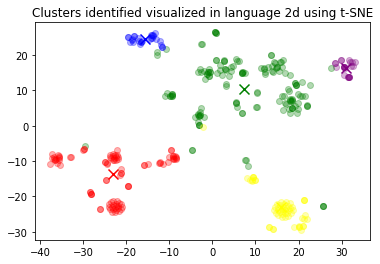

In [5]:
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow"]):
    xs = np.array(x)[embedding_df.Cluster == category]
    ys = np.array(y)[embedding_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [6]:
# We'll read 10 transactions per cluster as we're expecting some variation
transactions_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    transactions = "\n".join(
        embedding_df[embedding_df.Cluster == i]
        .combined.str.replace("Supplier: ", "")
        .str.replace("Description: ", ":  ")
        .str.replace("Value: ", ":  ")
        .sample(transactions_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        model=COMPLETIONS_MODEL,
        # We'll include a prompt to instruct the model what sort of description we're looking for
        prompt=f'''We want to group these transactions into meaningful clusters so we can target the areas we are spending the most money. 
                What do the following transactions have in common?\n\nTransactions:\n"""\n{transactions}\n"""\n\nTheme:''',
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = embedding_df[embedding_df.Cluster == i].sample(transactions_per_cluster, random_state=42)
    for j in range(transactions_per_cluster):
        print(sample_cluster_rows.Supplier.values[j], end=", ")
        print(sample_cluster_rows.Description.values[j], end="\n   ")
        #print(str(sample_cluster_rows.Value).values[j])

    print("-" * 100)


Cluster 0 Theme:  All of the transactions have to do with legal deposit services from the Agency for Legal Deposit Libraries (ALDL).
ALDL, ALDL Charges
   Agency for Legal Deposit Libaries, Agency services
   ALDL, Legal Deposit Services
   ALDL, ALDL Charges
   ALDL, Legal deposit services
   British Library, Legal Deposit Services
   ALDL, Legal deposit materials April to July 22
   ALDL, Jan20-Mar 20 charge from Agency for Legal Deposit Libraries
   ALDL, ALDL Charges
   ALDL, Legal Deposit Services
   ----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  These transactions all involve the purchase of goods or services from various vendors.
GARDINER AND THEOBALD LLP, GB Feasibility Study
   BSI, Annual subscription
   EX LIBRIS, IT equipment
   Private Sale, Literary & Archival Items
   XMA SCOTLAND LTD, 2 invoices one for the replacement of obsolete hardware and the other for a new laptop
   JISC SERVICES LTD SUBSCRIP

### Conclusion

We now have five new clusters that we can use to describe our data. Looking at the visualisation some of our clusters have some overlap and we'll need some tuning to get to the right place, but already we can see that GPT-3 has made some effective inferences. In particular, it picked up that items including legal deposits were related to literature archival, which is true but the model was given no clues on. Very cool, and with some tuning we can create a base set of clusters that we can then use with a multiclass classifier to generalise to other transactional datasets we might use.